# Optional: Install required libraries

In [ ]:
pip install boto3 psycopg2

# Load DWH Params from a file

In [7]:
import configparser
import pandas as pd

config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))


KEY                    = config.get('AWS','KEY')
SECRET                 = config.get('AWS','SECRET')

DWH_CLUSTER_TYPE       = config.get("DWH","DWH_CLUSTER_TYPE")
DWH_NUM_NODES          = config.get("DWH","DWH_NUM_NODES")
DWH_NODE_TYPE          = config.get("DWH","DWH_NODE_TYPE")
DWH_REGION             = config.get("DWH","DWH_REGION")
DWH_CLUSTER_IDENTIFIER = config.get("DWH","DWH_CLUSTER_IDENTIFIER")
DWH_IAM_ROLE_NAME      = config.get("DWH", "DWH_IAM_ROLE_NAME")

CLUSTER_DB             = config.get("CLUSTER","DB")
CLUSTER_DB_USER        = config.get("CLUSTER","DB_USER")
CLUSTER_DB_PASSWORD    = config.get("CLUSTER","DB_PASSWORD")
CLUSTER_PORT           = config.get("CLUSTER","PORT")


pd.DataFrame({"Param":
                  ["DWH_CLUSTER_TYPE", "DWH_NUM_NODES", "DWH_NODE_TYPE", "DWH_CLUSTER_IDENTIFIER", "CLUSTER_DB", "CLUSTER_DB_USER", "CLUSTER_DB_PASSWORD", "CLUSTER_PORT", "DWH_IAM_ROLE_NAME"],
              "Value":
                  [DWH_CLUSTER_TYPE, DWH_NUM_NODES, DWH_NODE_TYPE, DWH_CLUSTER_IDENTIFIER, CLUSTER_DB, CLUSTER_DB_USER, CLUSTER_DB_PASSWORD, CLUSTER_PORT, DWH_IAM_ROLE_NAME]
             })

,Param,Value
0,DWH_CLUSTER_TYPE,multi-node
1,DWH_NUM_NODES,4
2,DWH_NODE_TYPE,dc2.large
3,DWH_CLUSTER_IDENTIFIER,dwhCluster
4,CLUSTER_DB,dwh
5,CLUSTER_DB_USER,dwhuser
6,CLUSTER_DB_PASSWORD,Passw0rd
7,CLUSTER_PORT,5439
8,DWH_IAM_ROLE_NAME,dwhRole


# Create clients for IAM, EC2, S3 and Redshift

In [8]:
import boto3

ec2 = boto3.resource('ec2',
                       region_name=DWH_REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )

s3 = boto3.resource('s3',
                       region_name=DWH_REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                   )

iam = boto3.client('iam',aws_access_key_id=KEY,
                     aws_secret_access_key=SECRET,
                     region_name='us-west-2'
                  )

redshift = boto3.client('redshift',
                       region_name=DWH_REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                       )

# **STEP 1: IAM ROLE**

- Create an IAM Role that makes Redshift able to access S3 bucket (ReadOnly)

In [9]:
from botocore.exceptions import ClientError
import json

#1.1 Create the role, 
try:
    print("1.1 Creating a new IAM Role") 
    dwhRole = iam.create_role(
        Path='/',
        RoleName=DWH_IAM_ROLE_NAME,
        Description = "Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {'Statement': [{'Action': 'sts:AssumeRole',
               'Effect': 'Allow',
               'Principal': {'Service': 'redshift.amazonaws.com'}}],
             'Version': '2012-10-17'})
    )    
except Exception as e:
    print(e)
    
    
print("1.2 Attaching Policy")

iam.attach_role_policy(RoleName=DWH_IAM_ROLE_NAME,
                       PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
                      )['ResponseMetadata']['HTTPStatusCode']

print("1.3 Get the IAM role ARN")
roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

print(roleArn)

1.1 Creating a new IAM Role
An error occurred (EntityAlreadyExists) when calling the CreateRole operation: Role with name dwhRole already exists.
1.2 Attaching Policy
1.3 Get the IAM role ARN
arn:aws:iam::984642280787:role/dwhRole


# **STEP 2: Redshift Cluster**

- Create a [RedShift Cluster](https://console.aws.amazon.com/redshiftv2/home)
- For complete arguments to `create_cluster`, see [docs](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/redshift.html#Redshift.Client.create_cluster)

In [10]:
try:
    response = redshift.create_cluster(        
        #HW
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,
        NumberOfNodes=int(DWH_NUM_NODES),

        #Identifiers & Credentials
        DBName=CLUSTER_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=CLUSTER_DB_USER,
        MasterUserPassword=CLUSTER_DB_PASSWORD,
        
        #Roles (for s3 access)
        IamRoles=[roleArn]  
    )
except Exception as e:
    print(e)

# Describe the cluster to see its status
- run this block and wait until the cluster status becomes Available

In [11]:
import time

def prettyRedshiftProps(props):
    pd.set_option('display.max_colwidth', None)
    keysToShow = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']
    x = [(k, v) for k,v in props.items() if k in keysToShow]
    return pd.DataFrame(data=x, columns=["Key", "Value"])


# Define the interval in seconds between each status check
interval = 30


myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

# Use a while loop to call Redshift and check its status
while True:
    # Extract the ClusterStatus attribute from the response dictionary
    # cluster_status = [v for k,v in myClusterProps.items() if k == 'ClusterStatus'][0]
    cluster_status = myClusterProps.get('ClusterStatus')

    if cluster_status != 'available':
    # If status not available, print a message and wait for the specified interval
        print('Redshift is not yet available. Retrying in {} seconds...'.format(interval))
        time.sleep(interval)
    else:
    # If status is available, print status and break out of the loop
        print('Redshift is available!')
        break
    
    myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

prettyRedshiftProps(myClusterProps)

Redshift is not yet available. Retrying in 30 seconds...
Redshift is not yet available. Retrying in 30 seconds...
Redshift is not yet available. Retrying in 30 seconds...
Redshift is not yet available. Retrying in 30 seconds...
Redshift is not yet available. Retrying in 30 seconds...
Redshift is not yet available. Retrying in 30 seconds...
Redshift is not yet available. Retrying in 30 seconds...
Redshift is available!


,Key,Value
0,ClusterIdentifier,dwhcluster
1,NodeType,dc2.large
2,ClusterStatus,available
3,MasterUsername,dwhuser
4,DBName,dwh
5,Endpoint,"{'Address': 'dwhcluster.cmubyhpduf4v.us-west-2.redshift.amazonaws.com', 'Port': 5439}"
6,VpcId,vpc-0efbc6e38b4708c29
7,NumberOfNodes,4


# Take note of the cluster endpoint and role ARN 
<font color='red'>DO NOT RUN THIS unless the cluster status becomes "Available". </font>

In [12]:
CLUSTER_HOST = myClusterProps['Endpoint']['Address']
IAM_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']

#Set the value to cfg file
config.set("CLUSTER", "HOST", CLUSTER_HOST)
config.set("IAM_ROLE", "ARN", IAM_ROLE_ARN)

# Save the updated configuration to the file
with open('dwh.cfg', 'w') as config_file:
    config.write(config_file)

print("CLUSTER_HOST :: ", CLUSTER_HOST)
print("IAM_ROLE_ARN :: ", IAM_ROLE_ARN)

CLUSTER_HOST ::  dwhcluster.cmubyhpduf4v.us-west-2.redshift.amazonaws.com
IAM_ROLE_ARN ::  arn:aws:iam::984642280787:role/dwhRole


# **STEP 3: Open an incoming  TCP port to access the cluster ednpoint**

In [13]:
try:
    vpc = ec2.Vpc(id=myClusterProps['VpcId'])
    defaultSg = list(vpc.security_groups.all())[0]
    print(defaultSg)
    defaultSg.authorize_ingress(
        GroupName=defaultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort=int(CLUSTER_PORT),
        ToPort=int(CLUSTER_PORT)
    )
except Exception as e:
    print(e)

ec2.SecurityGroup(id='sg-0a4a18ff60208917b')
An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 0.0.0.0/0, TCP, from port: 5439, to port: 5439, ALLOW" already exists


# **Schema for SongPlay Analysis**


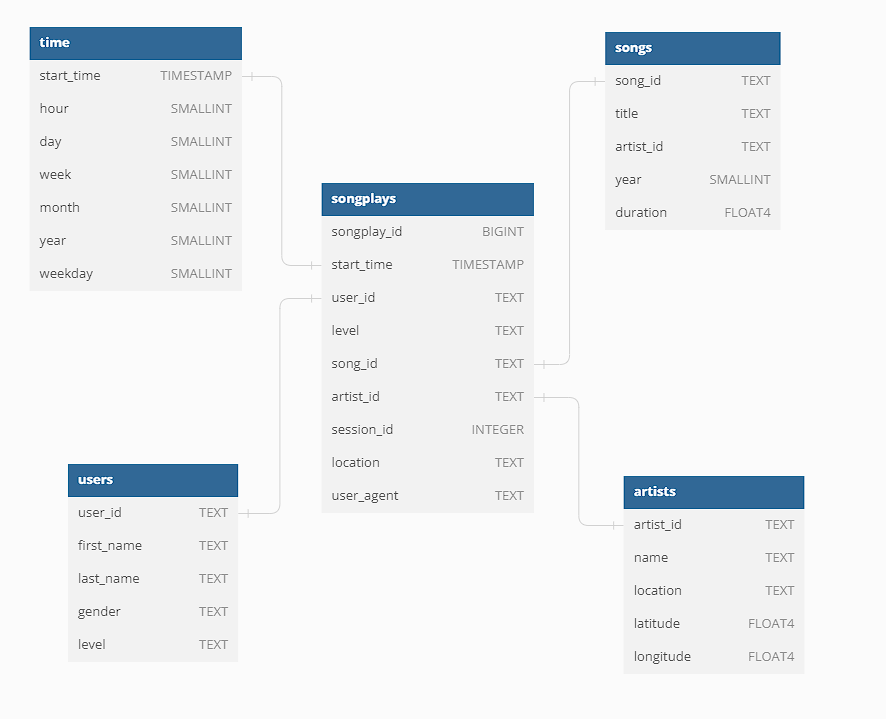


# Run below code to drop and recreate tables

In [14]:
%run create_tables.py

drop successfully
create tables successfully


# Run below code to create ETL pipeline

In [15]:
%run etl.py

loading: 
copy stage_events from 's3://udacity-dend/log_data'
    credentials 'aws_iam_role=arn:aws:iam::984642280787:role/dwhRole'
    region      'us-west-2'
    format       as JSON 's3://udacity-dend/log_json_path.json'
    timeformat   as 'epochmillisecs'

loading: 
    copy stage_songs from 's3://udacity-dend/song_data'
    credentials  'aws_iam_role=arn:aws:iam::984642280787:role/dwhRole'
    region       'us-west-2'
    format        as JSON 'auto'

inserting: 
    INSERT INTO songplays (start_time, user_id, level, song_id, artist_id, session_id, location, user_agent) 
    SELECT TIMESTAMP 'epoch' + (e.ts/1000 * INTERVAL '1 second'),
        e.user_id,
        e.level,
        s.song_id,
        s.artist_id,
        e.session_id,
        e.location,
        e.user_agent
    FROM stage_events e
    JOIN stage_songs s ON
        e.song = s.title AND
        e.artist = s.artist_name AND
        e.page = 'NextSong'

inserting: 
    INSERT INTO users SELECT DISTINCT (user_id)
      

# Example queries: What are the top 10 most played songs in 2018?

In [16]:
import psycopg2
from prettytable import PrettyTable

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))


# Create a cursor object to interact with the database
cur = conn.cursor()

# Execute the SELECT query
query = """
SELECT songs.title, artists.name as "artist name", COUNT(*) AS play_count
FROM songplays
JOIN songs ON songplays.song_id = songs.song_id
JOIN artists ON songplays.artist_id = artists.artist_id
JOIN time ON songplays.start_time = time.start_time
WHERE time.year = 2018
GROUP BY songs.title, artists.name
ORDER BY play_count DESC
LIMIT 10;
"""
cur.execute(query)

# Fetch all the results from the query
results = cur.fetchall()

# Create a pretty table object
table = PrettyTable()

# Get the column names
column_names = [desc[0] for desc in cur.description]

# Set the column names as table headers
table.field_names = column_names

# Add rows to the table
for row in results:
    table.add_row(row)

# Print the table
print(table)

# Close the cursor and the database connection
cur.close()
conn.close()

+------------------------------------------------------+--------------------------------+------------+
|                        title                         |          artist name           | play_count |
+------------------------------------------------------+--------------------------------+------------+
|                    You're The One                    |         Dwight Yoakam          |     37     |
| Catch You Baby (Steve Pitron & Max Sanna Radio Edit) |         Lonnie Gordon          |     9      |
|                 I CAN'T GET STARTED                  |           Ron Carter           |     9      |
|  Nothin' On You [feat. Bruno Mars] (Album Version)   |             B.o.B              |     8      |
|               Hey Daddy (Daddy's Home)               | Usher featuring Jermaine Dupri |     6      |
|               Hey Daddy (Daddy's Home)               |             Usher              |     6      |
|                     Up Up & Away                     |            Kid C

# **STEP 99: Clean up your resources**
DO NOT RUN THIS UNLESS YOU ARE SURE
We will be using these resources in the next exercises

In [17]:
#### CAREFUL!!
#-- Uncomment & run to delete the created resources
redshift.delete_cluster( ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,  SkipFinalClusterSnapshot=True)
#### CAREFUL!!

{'Cluster': {'ClusterIdentifier': 'dwhcluster',
  'NodeType': 'dc2.large',
  'ClusterStatus': 'deleting',
  'ClusterAvailabilityStatus': 'Modifying',
  'MasterUsername': 'dwhuser',
  'DBName': 'dwh',
  'Endpoint': {'Address': 'dwhcluster.cmubyhpduf4v.us-west-2.redshift.amazonaws.com',
   'Port': 5439},
  'ClusterCreateTime': datetime.datetime(2023, 8, 12, 14, 54, 37, 482000, tzinfo=tzutc()),
  'AutomatedSnapshotRetentionPeriod': 1,
  'ManualSnapshotRetentionPeriod': -1,
  'ClusterSecurityGroups': [],
  'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0a4a18ff60208917b',
    'Status': 'active'}],
  'ClusterParameterGroups': [{'ParameterGroupName': 'default.redshift-1.0',
    'ParameterApplyStatus': 'in-sync'}],
  'ClusterSubnetGroupName': 'default',
  'VpcId': 'vpc-0efbc6e38b4708c29',
  'AvailabilityZone': 'us-west-2d',
  'PreferredMaintenanceWindow': 'wed:11:00-wed:11:30',
  'PendingModifiedValues': {},
  'ClusterVersion': '1.0',
  'AllowVersionUpgrade': True,
  'NumberOfNodes': 4,
  '

- run this block and wait until the cluster really deleted

In [18]:
# Define the interval in seconds between each status check
interval = 30

# Use a while loop to call Redshift and check its status
while True:
    try:
        myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

        # Extract the ClusterStatus attribute from the response dictionary
        cluster_status = [v for k,v in myClusterProps.items() if k == 'ClusterStatus'][0]

        if cluster_status == 'deleting':
        # If status is deleting, print a message and wait for the specified interval
            print('Redshift is not deleted yet. Retrying in {} seconds...'.format(interval))
            time.sleep(interval)
    except Exception as e:
        print(e)
        break



Redshift is not deleted yet. Retrying in 30 seconds...
Redshift is not deleted yet. Retrying in 30 seconds...
Redshift is not deleted yet. Retrying in 30 seconds...
An error occurred (ClusterNotFound) when calling the DescribeClusters operation: Cluster dwhcluster not found.


In [19]:
#### CAREFUL!!
#-- Uncomment & run to delete the created resources
iam.detach_role_policy(RoleName=DWH_IAM_ROLE_NAME, PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess")
iam.delete_role(RoleName=DWH_IAM_ROLE_NAME)
#### CAREFUL!!

{'ResponseMetadata': {'RequestId': '8ef8cd02-899a-440c-a653-83bcde83c1ec',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8ef8cd02-899a-440c-a653-83bcde83c1ec',
   'content-type': 'text/xml',
   'content-length': '200',
   'date': 'Sat, 12 Aug 2023 15:01:18 GMT'},
  'RetryAttempts': 0}}